<a href="https://colab.research.google.com/github/terrysu64/Machine-Learning-and-Data-Science-Projects/blob/main/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - fine-tuning

In [ ]:
!nvidia-smi

Sun Aug  7 00:24:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### import helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-07 00:24:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-07 00:24:02 (83.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

### get data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-08-07 00:24:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.130.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   113MB/s    in 1.4s    

2022-08-07 00:24:07 (113 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (225,225); BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data, train_data.class_names

(<BatchDataset element_spec=(TensorSpec(shape=(None, 225, 225, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

In [ ]:
#visualize a batch
for imgs, labels in train_data.take(1):
  print(imgs, labels)

tf.Tensor(
[[[[1.26509262e+02 7.42782440e+01 2.77402802e+01]
   [1.58242523e+02 1.03321693e+02 4.89753036e+01]
   [1.59428772e+02 1.01171455e+02 3.67963676e+01]
   ...
   [5.59288750e+01 1.42409344e+01 7.82666683e+00]
   [5.03224983e+01 1.09372158e+01 4.04694319e+00]
   [4.97268486e+01 1.08688307e+01 3.45129299e+00]]

  [[7.63947067e+01 2.68591537e+01 1.10548049e-01]
   [1.17834183e+02 6.69133377e+01 1.99924889e+01]
   [1.40675323e+02 8.53834076e+01 2.81789627e+01]
   ...
   [9.04400024e+01 3.59599991e+01 2.91005955e+01]
   [8.41649704e+01 3.17075062e+01 2.38583050e+01]
   [8.12905426e+01 2.89047279e+01 2.21488476e+01]]

  [[7.52457352e+01 2.59884224e+01 8.59654963e-01]
   [1.15723038e+02 6.38963737e+01 2.41563740e+01]
   [1.44277161e+02 9.00619736e+01 3.92707405e+01]
   ...
   [1.13224548e+02 4.56578827e+01 3.64689941e+01]
   [1.09291931e+02 4.45363731e+01 3.55363731e+01]
   [1.13910713e+02 4.91551552e+01 4.01551552e+01]]

  ...

  [[2.13607742e+02 1.73775620e+02 1.48500061e+02]
   [2

### experiment 1: pure feature extraction + data augmentation

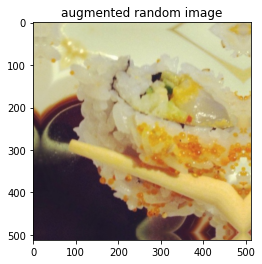

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing as pre #augments on gpu and only during train
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import os

data_aug = tf.keras.Sequential([
    pre.RandomFlip("horizontal"),
    pre.RandomRotation(0.2),
    pre.RandomZoom(0.2)
], name="data_augmentation")

target_class = random.choice(train_data.class_names)
target_dir = ''.join([train_dir,'/',target_class])
img = ''.join([target_dir,
               '/',
               random.choice(os.listdir(target_dir))])

aug_img = data_aug(mpimg.imread(img))
plt.title('augmented random image')
plt.imshow(aug_img/255)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(IMG_SIZE)+(3,), name="input_layer") #normalizing not needed for efficientnet
#x = data_aug(inputs, training=True)
x = base_model(inputs)
print(x.shape)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
print(x.shape)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step
(None, 7, 7, 1280)
(None, 1280)


In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
#model checkpoint callback
save_path = "model_checkpoints/checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [ ]:
history = model.fit(train_data,
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(len(test_data)/4),
                    callbacks=[checkpoint_callback,
                               create_tensorboard_callback(dir_name="models",
                                                           experiment_name="feature_extraction")])

Saving TensorBoard log files to: models/feature_extraction/20220807-002426
Epoch 1/3
24/24 [==============================] - ETA: 0s - loss: 1.8659 - accuracy: 0.4080
Epoch 1: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 24s 277ms/step - loss: 1.8659 - accuracy: 0.4080 - val_loss: 1.3223 - val_accuracy: 0.7204
Epoch 2/3
23/24 [===========================>..] - ETA: 0s - loss: 1.1289 - accuracy: 0.7296
Epoch 2: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 4s 164ms/step - loss: 1.1313 - accuracy: 0.7267 - val_loss: 0.9023 - val_accuracy: 0.7993
Epoch 3/3
23/24 [===========================>..] - ETA: 0s - loss: 0.8225 - accuracy: 0.8030
Epoch 3: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 5s 196ms/step - loss: 0.8255 - accuracy: 0.8000 - val_loss: 0.7400 - val_accuracy: 0.8174


In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.7484 - accuracy: 0.8204


[0.7484008073806763, 0.8203999996185303]

In [ ]:
for i,layer in enumerate(base_model.layers): print(i, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

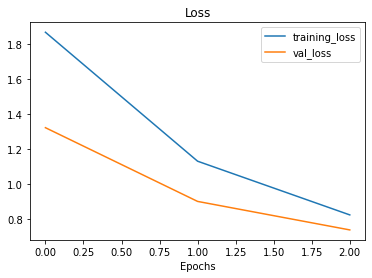

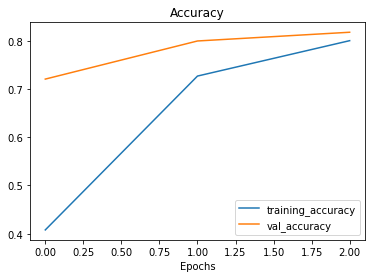

In [ ]:
plot_loss_curves(history)

### getting a feature vector

In [ ]:
#globalavgpool2d compresses 4-d to 2-d via averaging middle 2 axis to make a feature vector

tf.random.set_seed(42)

input_shape = (1,4,4,3)
tensor = tf.random.normal(input_shape)

pooled_tensor = tf.keras.layers.GlobalAvgPool2D()(tensor)
tensor.shape,pooled_tensor.shape


(TensorShape([1, 4, 4, 3]), TensorShape([1, 3]))

### loading checkpoints and weights

In [ ]:
#load and evaluate

model.load_weights(save_path)

In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 7s 74ms/step - loss: 0.7484 - accuracy: 0.8204


[0.7484009265899658, 0.8203999996185303]

### experiment 2: fine-tuning 

**note**: usually works best after training for a few epochs fist

In [ ]:
model.layers

In [ ]:
[(layer,layer.trainable )for layer in model.layers[1].layers] #layers in borrowed model

[(<keras.engine.input_layer.InputLayer at 0x7f0f95c56c90>, False),
 (<keras.layers.preprocessing.image_preprocessing.Rescaling at 0x7f0f95c56910>,
  False),
 (<keras.layers.preprocessing.normalization.Normalization at 0x7f0f974af850>,
  False),
 (<keras.layers.convolutional.ZeroPadding2D at 0x7f0f95ce8690>, False),
 (<keras.layers.convolutional.Conv2D at 0x7f0f95d49990>, False),
 (<keras.layers.normalization.batch_normalization.BatchNormalization at 0x7f0f95d96d90>,
  False),
 (<keras.layers.core.activation.Activation at 0x7f0f95cde990>, False),
 (<keras.layers.convolutional.DepthwiseConv2D at 0x7f0f8445b410>, False),
 (<keras.layers.normalization.batch_normalization.BatchNormalization at 0x7f0f84404d10>,
  False),
 (<keras.layers.core.activation.Activation at 0x7f0f95c3bd10>, False),
 (<keras.layers.pooling.GlobalAveragePooling2D at 0x7f0f844143d0>, False),
 (<keras.layers.core.reshape.Reshape at 0x7f0f84412e50>, False),
 (<keras.layers.convolutional.Conv2D at 0x7f0f95cde450>, False),

In [ ]:
#unfreeze last 10 layers

base_model.trainable = True
for layer in base_model.layers[:-10]: layer.trainable=False



In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #rule of thumb is to lower lr for fine-tuning
              metrics=["accuracy"])

In [ ]:
len(model.trainable_variables)

12

In [ ]:
history = model.fit(train_data,
                    epochs=3+5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(len(test_data)/4),
                    initial_epoch=history.epoch[-1], #start training where last model left off
                    callbacks=[checkpoint_callback,
                               create_tensorboard_callback(dir_name="models",
                                                           experiment_name="fine_tuning")])

Saving TensorBoard log files to: models/fine_tuning/20220807-002721
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.7951 - accuracy: 0.8093
Epoch 3: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 14s 260ms/step - loss: 0.7951 - accuracy: 0.8093 - val_loss: 0.6259 - val_accuracy: 0.8158
Epoch 4/8
23/24 [===========================>..] - ETA: 0s - loss: 0.6444 - accuracy: 0.8370
Epoch 4: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 4s 170ms/step - loss: 0.6443 - accuracy: 0.8387 - val_loss: 0.5618 - val_accuracy: 0.8339
Epoch 5/8
23/24 [===========================>..] - ETA: 0s - loss: 0.5174 - accuracy: 0.8859
Epoch 5: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 5s 201ms/step - loss: 0.5116 - accuracy: 0.8880 - val_loss: 0.5334 - val_accuracy: 0.8438
Epoch 6/8
23/24 [===========================>..] - ETA: 0s - loss: 0.4424 - accura

In [ ]:
results = model.evaluate(test_data)

79/79 [==============================] - 8s 88ms/step - loss: 0.4650 - accuracy: 0.8556


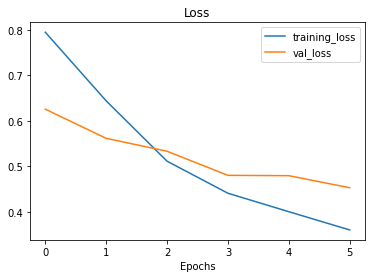

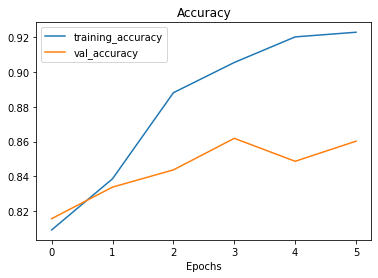

In [ ]:
plot_loss_curves(history) #need to reduce overfitting

In [ ]:
#can revert back the fine tuning via loading the checkpoint weights